In [1]:
!pip install datasets
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("tomaarsen/setfit-absa-semeval-laptops")

# Print dataset information
print(dataset)
import pandas as pd

# Convert train split to a pandas DataFrame
train_df = pd.DataFrame(dataset["train"])

# Save train DataFrame to CSV
train_df.to_csv("train_dataset.csv", index=False)

# Convert test split to a pandas DataFrame
test_df = pd.DataFrame(dataset["test"])

# Save test DataFrame to CSV
test_df.to_csv("test_dataset.csv", index=False)


  Using cached datasets-2.19.1-py3-none-any.whl.metadata (19 kB)
  Using cached pyarrow-16.0.0-cp310-cp310-win_amd64.whl.metadata (3.1 kB)
  Using cached pyarrow_hotfix-0.6-py3-none-any.whl.metadata (3.6 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached xxhash-3.4.1-cp310-cp310-win_amd64.whl.metadata (12 kB)
  Using cached multiprocess-0.70.16-py310-none-any.whl.metadata (7.2 kB)
  Using cached aiohttp-3.9.5-cp310-cp310-win_amd64.whl.metadata (7.7 kB)
  Using cached huggingface_hub-0.23.0-py3-none-any.whl.metadata (12 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached frozenlist-1.4.1-cp310-cp310-win_amd64.whl.metadata (12 kB)
  Using cached multidict-6.0.5-cp310-cp310-win_amd64.whl.metadata (4.3 kB)
  Using cached yarl-1.9.4-cp310-cp310-win_amd64.whl.metadata (32 kB)
  Using cached async_timeout-4.0.3-py3-none-any.whl.metadata (4.2 kB)
Using cached datasets-2.19.1-py3-none-any.whl (542 kB)
Using cached dill-0.3.8-py3-none-

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
adapter-transformers 3.2.1.post0 requires huggingface-hub<0.14.0,>=0.11.0, but you have huggingface-hub 0.23.0 which is incompatible.
transformers 4.40.1 requires tokenizers<0.20,>=0.19, but you have tokenizers 0.13.3 which is incompatible.


Generating train split:   0%|          | 0/2358 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/654 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'span', 'label', 'ordinal'],
        num_rows: 2358
    })
    test: Dataset({
        features: ['text', 'span', 'label', 'ordinal'],
        num_rows: 654
    })
})


In [3]:
train_df

,text,span,label,ordinal
0,I charge it at night and skip taking the cord ...,cord,neutral,0
1,I charge it at night and skip taking the cord ...,battery life,positive,0
2,The tech guy then said the service center does...,service center,negative,0
3,The tech guy then said the service center does...,"""sales"" team",negative,0
4,The tech guy then said the service center does...,tech guy,neutral,0
...,...,...,...,...
2353,We also use Paralles so we can run virtual mac...,Windows Server Enterprise 2003,neutral,0
2354,We also use Paralles so we can run virtual mac...,Windows Server 2008 Enterprise,neutral,0
2355,"How Toshiba handles the repair seems to vary, ...",repair,conflict,0
2356,"How Toshiba handles the repair seems to vary, ...",repair,positive,1


In [8]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# Step 1: Data Preprocessing
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_data(data_df):
    encodings = []
    for i in tqdm(range(len(data_df))):
        text = data_df.loc[i, "text"]
        aspect_span = data_df.loc[i, "span"]
        aspect = data_df.loc[i, "label"]
        label = data_df.loc[i, "ordinal"]
        
        start_idx = text.find(aspect_span)
        end_idx = start_idx + len(aspect_span)
        
        encoding = tokenizer(text, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
        encoding['aspect_start'] = start_idx
        encoding['aspect_end'] = end_idx
        encoding['aspect'] = aspect
        encoding['label'] = label
        encodings.append(encoding)
    
    input_ids = torch.cat([enc['input_ids'] for enc in encodings], dim=0)
    attention_mask = torch.cat([enc['attention_mask'] for enc in encodings], dim=0)
    aspect_start = torch.tensor([enc['aspect_start'] for enc in encodings])
    aspect_end = torch.tensor([enc['aspect_end'] for enc in encodings])
    labels = torch.tensor([enc['label'] for enc in encodings])
    
    return input_ids, attention_mask, aspect_start, aspect_end, labels

train_input_ids, train_attention_mask, train_aspect_start, train_aspect_end, train_labels = preprocess_data(train_df)
test_input_ids, test_attention_mask, test_aspect_start, test_aspect_end, test_labels = preprocess_data(test_df)

train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_aspect_start, train_aspect_end, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_aspect_start, test_aspect_end, test_labels)

# Step 2: Fine-tune BERT Model
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(train_labels_encoded)))
optimizer = AdamW(model.parameters(), lr=5e-5)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

batch_size = 16
num_epochs = 3

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[4].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {total_loss}")

# Step 3: Evaluation
test_loader = DataLoader(test_dataset, batch_size=batch_size)
model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[4].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
print(f"Test Accuracy: {accuracy}")


100%|██████████████████████████████████████████████████████████████████████████████| 654/654 [00:00<00:00, 1291.29it/s]
C:\Users\thema\anaconda3\envs\tough\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassificat

Epoch 1, Loss: 25.537843205034733
Epoch 2, Loss: 18.45649208407849
Epoch 3, Loss: 16.835702679585665
Test Accuracy: 0.9923547400611621


C:\Users\thema\anaconda3\envs\tough\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
100%|██████████████████████████████████████████████████████████████████████████████| 654/654 [00:00<00:00, 1375.22it/s]
C:\Users\thema\anaconda3\envs\tough\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.pre

Epoch 1/20, Loss: 0.1960, Accuracy: 0.9538


Epoch 2/20: 100%|████████████████████████████████████████████████████████████████████| 148/148 [00:53<00:00,  2.76it/s]


Epoch 2/20, Loss: 0.1204, Accuracy: 0.9707


Epoch 3/20: 100%|████████████████████████████████████████████████████████████████████| 148/148 [00:53<00:00,  2.76it/s]


Epoch 3/20, Loss: 0.1016, Accuracy: 0.9707


Epoch 4/20: 100%|████████████████████████████████████████████████████████████████████| 148/148 [00:53<00:00,  2.76it/s]


Epoch 4/20, Loss: 0.1048, Accuracy: 0.9703


Epoch 5/20: 100%|████████████████████████████████████████████████████████████████████| 148/148 [00:53<00:00,  2.76it/s]


Epoch 5/20, Loss: 0.0841, Accuracy: 0.9703


Epoch 6/20: 100%|████████████████████████████████████████████████████████████████████| 148/148 [00:53<00:00,  2.76it/s]


Epoch 6/20, Loss: 0.0849, Accuracy: 0.9695


Epoch 7/20: 100%|████████████████████████████████████████████████████████████████████| 148/148 [00:54<00:00,  2.73it/s]


Epoch 7/20, Loss: 0.0738, Accuracy: 0.9656


Epoch 8/20: 100%|████████████████████████████████████████████████████████████████████| 148/148 [00:53<00:00,  2.75it/s]


Epoch 8/20, Loss: 0.0803, Accuracy: 0.9695


Epoch 9/20: 100%|████████████████████████████████████████████████████████████████████| 148/148 [00:58<00:00,  2.54it/s]


Epoch 9/20, Loss: 0.0712, Accuracy: 0.9682


Epoch 10/20: 100%|███████████████████████████████████████████████████████████████████| 148/148 [00:53<00:00,  2.76it/s]


Epoch 10/20, Loss: 0.0831, Accuracy: 0.9695


Epoch 11/20: 100%|███████████████████████████████████████████████████████████████████| 148/148 [00:53<00:00,  2.76it/s]


Epoch 11/20, Loss: 0.0740, Accuracy: 0.9695


Epoch 12/20: 100%|███████████████████████████████████████████████████████████████████| 148/148 [00:53<00:00,  2.77it/s]


Epoch 12/20, Loss: 0.0636, Accuracy: 0.9707


Epoch 13/20: 100%|███████████████████████████████████████████████████████████████████| 148/148 [00:53<00:00,  2.76it/s]


Epoch 13/20, Loss: 0.0578, Accuracy: 0.9720


Epoch 14/20: 100%|███████████████████████████████████████████████████████████████████| 148/148 [00:53<00:00,  2.75it/s]


Epoch 14/20, Loss: 0.0661, Accuracy: 0.9690


Epoch 15/20: 100%|███████████████████████████████████████████████████████████████████| 148/148 [00:53<00:00,  2.76it/s]


Epoch 15/20, Loss: 0.0702, Accuracy: 0.9699


Epoch 16/20: 100%|███████████████████████████████████████████████████████████████████| 148/148 [00:53<00:00,  2.77it/s]


Epoch 16/20, Loss: 0.0659, Accuracy: 0.9652


Epoch 17/20: 100%|███████████████████████████████████████████████████████████████████| 148/148 [00:53<00:00,  2.76it/s]


Epoch 17/20, Loss: 0.0628, Accuracy: 0.9707


Epoch 18/20: 100%|███████████████████████████████████████████████████████████████████| 148/148 [00:53<00:00,  2.76it/s]


Epoch 18/20, Loss: 0.0649, Accuracy: 0.9690


Epoch 19/20: 100%|███████████████████████████████████████████████████████████████████| 148/148 [00:53<00:00,  2.75it/s]


Epoch 19/20, Loss: 0.0661, Accuracy: 0.9673


Epoch 20/20: 100%|███████████████████████████████████████████████████████████████████| 148/148 [00:53<00:00,  2.77it/s]


Epoch 20/20, Loss: 0.0601, Accuracy: 0.9686


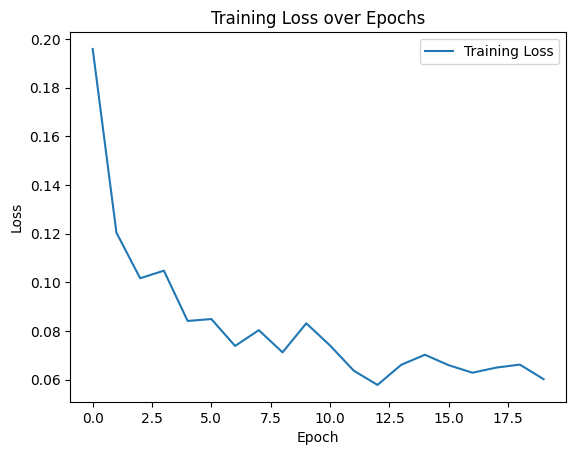

Test Accuracy: 0.9923547400611621


In [29]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt

# Step 1: Data Preprocessing
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_data(data_df):
    encodings = []
    for i in tqdm(range(len(data_df))):
        text = data_df.loc[i, "text"]
        aspect_span = data_df.loc[i, "span"]
        aspect = data_df.loc[i, "label"]
        label = data_df.loc[i, "ordinal"]
        
        start_idx = text.find(aspect_span)
        end_idx = start_idx + len(aspect_span)
        
        encoding = tokenizer(text, truncation=True, padding='max_length', max_length=128, return_tensors='pt')
        encoding['aspect_start'] = start_idx
        encoding['aspect_end'] = end_idx
        encoding['aspect'] = aspect
        encoding['label'] = label
        encodings.append(encoding)
    
    input_ids = torch.cat([enc['input_ids'] for enc in encodings], dim=0)
    attention_mask = torch.cat([enc['attention_mask'] for enc in encodings], dim=0)
    aspect_start = torch.tensor([enc['aspect_start'] for enc in encodings])
    aspect_end = torch.tensor([enc['aspect_end'] for enc in encodings])
    labels = torch.tensor([enc['label'] for enc in encodings])
    
    return input_ids, attention_mask, aspect_start, aspect_end, labels

train_input_ids, train_attention_mask, train_aspect_start, train_aspect_end, train_labels = preprocess_data(train_df)
test_input_ids, test_attention_mask, test_aspect_start, test_aspect_end, test_labels = preprocess_data(test_df)

train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_aspect_start, train_aspect_end, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_aspect_start, test_aspect_end, test_labels)

# Step 2: Fine-tune BERT Model
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(set(train_labels_encoded)))
optimizer = AdamW(model.parameters(), lr=5e-5)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

batch_size = 16
num_epochs = 20

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Lists to store training loss and accuracy
train_loss_list = []
train_accuracy_list = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[4].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.logits, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)
        
        loss.backward()
        optimizer.step()
    
    # Calculate epoch loss and accuracy
    epoch_loss = total_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions
    
    # Append to lists
    train_loss_list.append(epoch_loss)
    train_accuracy_list.append(epoch_accuracy)
    
    # Print epoch loss and accuracy
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

# Plot training loss over epochs
plt.plot(train_loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

# Step 3: Evaluation
test_loader = DataLoader(test_dataset, batch_size=batch_size)
model.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[4].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
print(f"Test Accuracy: {accuracy}")


In [44]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import warnings
warnings.filterwarnings("ignore")

# Load pre-trained model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name)

# Function to predict aspect sentiment
def predict_aspect_sentiment(text, aspect_span):
    # Tokenize input text
    inputs = tokenizer(text, return_tensors='pt')

    # Find start and end positions of aspect span
    aspect_start_idx = text.find(aspect_span)
    aspect_end_idx = aspect_start_idx + len(aspect_span)

    # Get token IDs and attention mask
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Get predictions from the model
    outputs = model(input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()

    return predicted_label  # Return the predicted sentiment label

# Input text and aspect span
input_text = "The product battery is bad but display is awesome."
aspect_span = "display"

# Predict aspect sentiment
predicted_sentiment = predict_aspect_sentiment(input_text, aspect_span)

# Print the predicted sentiment
print(f"Predicted sentiment for aspect {aspect_span}:", predicted_sentiment)



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

Predicted sentiment for aspect display: 0


In [43]:
# Define directory paths to save the model and tokenizer
model_dir = "aspect_sentiment_model"
tokenizer_dir = "aspect_sentiment_tokenizer"

# Create the directory if it doesn't exist
import os
os.makedirs(model_dir, exist_ok=True)
os.makedirs(tokenizer_dir, exist_ok=True)

# Save the model and tokenizer
model.save_pretrained(model_dir)
tokenizer.save_pretrained(tokenizer_dir)


('aspect_sentiment_tokenizer\\tokenizer_config.json',
 'aspect_sentiment_tokenizer\\special_tokens_map.json',
 'aspect_sentiment_tokenizer\\vocab.txt',
 'aspect_sentiment_tokenizer\\added_tokens.json')

In [28]:
# # Load saved model and tokenizer
# from transformers import BertTokenizer, BertForSequenceClassification

# model_dir = "aspect_sentiment_model"
# tokenizer_dir = "aspect_sentiment_tokenizer"

# model = BertForSequenceClassification.from_pretrained(model_dir)
# tokenizer = BertTokenizer.from_pretrained(tokenizer_dir)
